No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


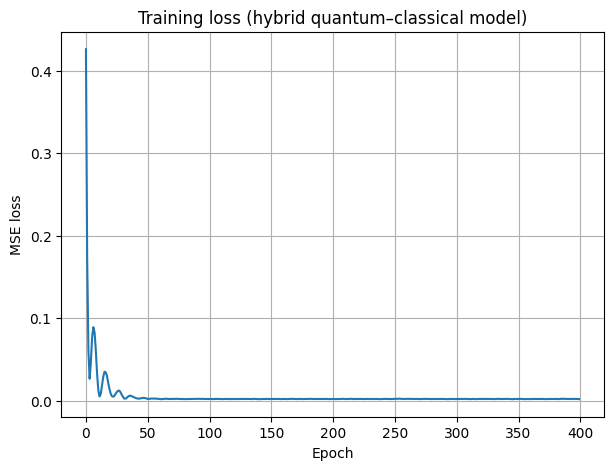

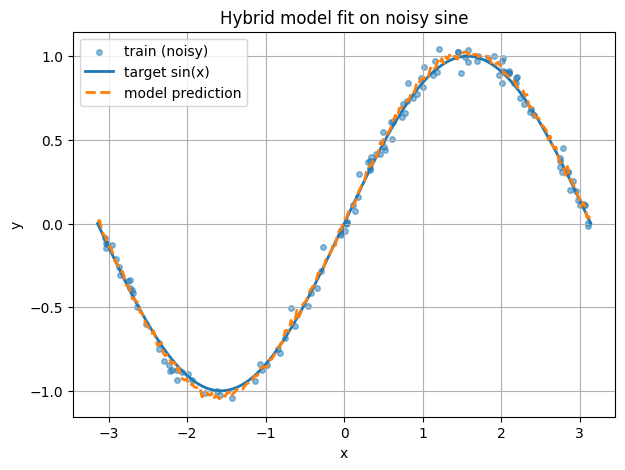

In [2]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Reproducibility
torch.manual_seed(3)
np.random.seed(3)

# ----- Quantum feature map: U(θ;x) = RY(x) RZ(θ) -----
x_par = Parameter("x")
theta = Parameter("θ")
qc = QuantumCircuit(1, name="U(θ;x)")
qc.ry(x_par, 0)
qc.rz(theta, 0)

Z = SparsePauliOp.from_list([("Z", 1.0)])
X = SparsePauliOp.from_list([("X", 1.0)])

estimator = StatevectorEstimator()


qnn = EstimatorQNN(
    circuit=qc,
    observables=[Z, X],     # -> 2-D features [<Z>, <X>]
    input_params=[x_par],
    weight_params=[theta],
    estimator=estimator,
    
)

q_layer = TorchConnector(qnn, initial_weights=[0.1])  # no tensor-copy warning

# ----- Classical head (nonlinear): 2 -> 32 -> 1 -----
class HybridModel(nn.Module):
    def __init__(self, q_layer):
        super().__init__()
        self.q_layer = q_layer
        self.mlp = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
        )
    def forward(self, xb):
        if xb.ndim == 1:
            xb = xb.view(-1, 1)
        feats = self.q_layer(xb)   # [batch, 2] = [<Z>, <X>]
        return self.mlp(feats)

model = HybridModel(q_layer)

# ----- Data: y = sin(x) + small noise -----
N_train, N_test = 128, 256
x_train = (2*np.pi) * torch.rand(N_train, 1, dtype=torch.float32) - np.pi
y_train = torch.sin(x_train) + 0.05*torch.randn_like(x_train)

x_test = torch.linspace(-np.pi, np.pi, N_test).view(-1, 1)
y_test = torch.sin(x_test)

# ----- Train -----
opt = optim.Adam(model.parameters(), lr=0.03)
loss_fn = nn.MSELoss()
loss_hist = []

for ep in range(400):
    opt.zero_grad()
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    opt.step()
    loss_hist.append(loss.item())

# ----- Evaluate -----
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

# ----- Plot 1: loss curve -----
plt.figure(figsize=(7,5))
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training loss (hybrid quantum–classical model)")
plt.grid(True)
plt.show()

# ----- Plot 2: predictions vs ground truth -----
plt.figure(figsize=(7,5))
plt.scatter(x_train.numpy().ravel(), y_train.numpy().ravel(), s=16, alpha=0.5, label="train (noisy)")
plt.plot(x_test.numpy().ravel(), y_test.numpy().ravel(), linewidth=2, label="target sin(x)")
plt.plot(x_test.numpy().ravel(), y_pred.numpy().ravel(), linewidth=2, linestyle="--", label="model prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Hybrid model fit on noisy sine")
plt.legend()
plt.grid(True)
plt.show()


Learned quantum θ: [0.02712172]


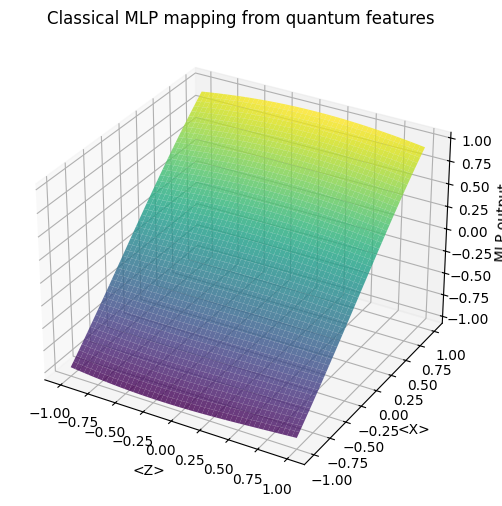

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Get learned θ from quantum layer
theta_learned = model.q_layer.weight.detach().numpy()
print("Learned quantum θ:", theta_learned)

# Make a grid in the feature space
z_vals = np.linspace(-1, 1, 50)  # <Z>
x_vals = np.linspace(-1, 1, 50)  # <X>
Z_grid, X_grid = np.meshgrid(z_vals, x_vals)
features_grid = np.column_stack([Z_grid.ravel(), X_grid.ravel()])

# Pass only through classical MLP
with torch.no_grad():
    outputs = model.mlp(torch.tensor(features_grid, dtype=torch.float32)).numpy()

# Reshape for plotting
outputs = outputs.reshape(Z_grid.shape)

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z_grid, X_grid, outputs, cmap='viridis', alpha=0.8)
ax.set_xlabel('<Z>')
ax.set_ylabel('<X>')
ax.set_zlabel('MLP output')
ax.set_title('Classical MLP mapping from quantum features')
plt.show()


/tmp/ipykernel_4032/886966925.py:28: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


epoch  60 | loss 0.0547 | acc 0.986
epoch 120 | loss 0.0549 | acc 0.982
epoch 180 | loss 0.0322 | acc 0.973
epoch 240 | loss 0.0327 | acc 0.973
epoch 300 | loss 0.0321 | acc 0.980
test accuracy: 0.984375


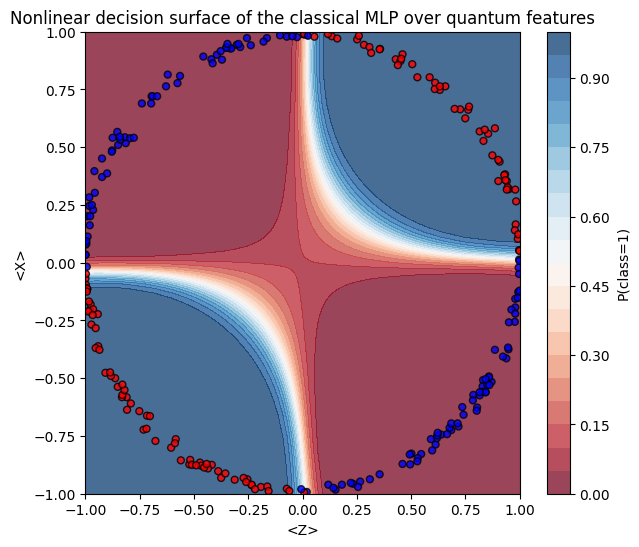

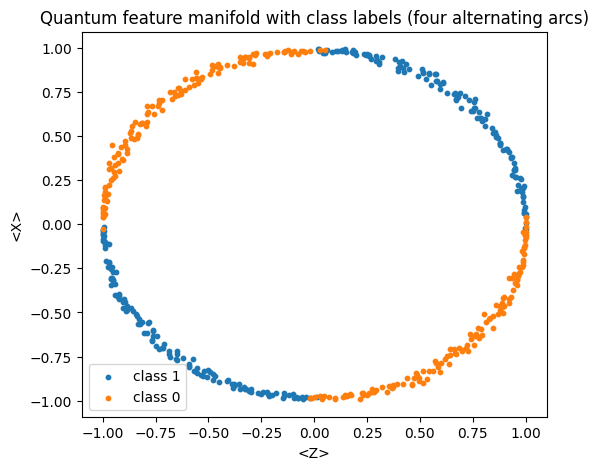

In [4]:
# pip install -U "qiskit>=1.4" "qiskit-machine-learning>=0.8.3"
# pip install "torch>=2.3" --index-url https://download.pytorch.org/whl/cpu
import numpy as np, torch
from torch import nn, optim
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator as AerEstimator        # V1 Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

torch.manual_seed(7); np.random.seed(7)

# --- Quantum feature map: U(θ;x) = RY(x) RZ(θ) ---
x_par, theta = Parameter("x"), Parameter("θ")
qc = QuantumCircuit(1, name="U(θ;x)")
qc.ry(x_par, 0); qc.rz(theta, 0)

Z = SparsePauliOp.from_list([("Z", 1.0)])
X = SparsePauliOp.from_list([("X", 1.0)])

estimator = AerEstimator()                                  # shotless statevector sim ok too
grad = ParamShiftEstimatorGradient(estimator)               # analytic grad (V1)

qnn = EstimatorQNN(
    circuit=qc,
    observables=[Z, X],     # -> 2-D features [<Z>, <X>]
    input_params=[x_par],
    weight_params=[theta],
    estimator=estimator,
    gradient=grad,
)
q_layer = TorchConnector(qnn, initial_weights=[0.2])        # avoid tensor-copy warning

# --- Classical head (nonlinear) ---
class Hybrid(nn.Module):
    def __init__(self, q_layer):
        super().__init__()
        self.q_layer = q_layer
        self.mlp = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 1),   # logits
        )
    def forward(self, xb):
        if xb.ndim == 1: xb = xb.view(-1, 1)
        feats = self.q_layer(xb)         # [batch, 2] = [<Z>, <X>]
        return self.mlp(feats)

model = Hybrid(q_layer)

# --- Data: XOR-like labels on the circle: y = 1[ sin(2x) > 0 ] ---
N_train, N_test = 256, 512
x_train = (2*np.pi)*torch.rand(N_train, 1, dtype=torch.float32) - np.pi
y_train = (torch.sin(2*x_train) > 0).float()                # {0,1}
x_test  = torch.linspace(-np.pi, np.pi, N_test).view(-1,1)
y_test  = (torch.sin(2*x_test) > 0).float()

# --- Train ---
opt = optim.Adam(model.parameters(), lr=0.03)
loss_fn = nn.BCEWithLogitsLoss()
for ep in range(300):
    opt.zero_grad()
    logits = model(x_train)
    loss = loss_fn(logits, y_train)
    loss.backward(); opt.step()
    if (ep+1) % 60 == 0:
        with torch.no_grad():
            acc = ((torch.sigmoid(model(x_test))>0.5) == y_test).float().mean().item()
        print(f"epoch {ep+1:3d} | loss {loss.item():.4f} | acc {acc:.3f}")

# --- Evaluate ---
with torch.no_grad():
    probs = torch.sigmoid(model(x_test))
    acc = ((probs>0.5)==y_test).float().mean().item()
print("test accuracy:", acc)

# --- Plot 1: points in feature space colored by label, plus learned decision surface ---
# Build grid in ( <Z>, <X> ) space
grid = 100
z_axis = np.linspace(-1, 1, grid)         # <Z>
x_axis = np.linspace(-1, 1, grid)         # <X>
Zg, Xg = np.meshgrid(z_axis, x_axis)
feat_grid = np.column_stack([Zg.ravel(), Xg.ravel()])

# MLP only (skip quantum) to show the classical nonlinearity
with torch.no_grad():
    logits_grid = model.mlp(torch.tensor(feat_grid, dtype=torch.float32)).numpy()
    probs_grid = 1 / (1 + np.exp(-logits_grid))
probs_grid = probs_grid.reshape(Zg.shape)

# Map training points into feature space to overlay
with torch.no_grad():
    feats_train = model.q_layer(x_train).numpy()
    z_feat, x_feat = feats_train[:,0], feats_train[:,1]
    y_lbl = y_train.numpy().ravel()

plt.figure(figsize=(7,6))
cs = plt.contourf(Zg, Xg, probs_grid, levels=21, alpha=0.75, cmap="RdBu")
cbar = plt.colorbar(cs); cbar.set_label("P(class=1)")
plt.scatter(z_feat, x_feat, c=y_lbl, cmap="bwr", edgecolor="k", s=25, alpha=0.8)
plt.xlabel("<Z>"); plt.ylabel("<X>")
plt.title("Nonlinear decision surface of the classical MLP over quantum features")
plt.show()

# --- Plot 2: decision along the circle (the manifold quantum features live on) ---
with torch.no_grad():
    feats_test = model.q_layer(x_test).numpy()
plt.figure(figsize=(6,5))
mask = (y_test.numpy().ravel() == 1)
plt.scatter(feats_test[mask,0], feats_test[mask,1], s=10, label="class 1")
plt.scatter(feats_test[~mask,0], feats_test[~mask,1], s=10, label="class 0")
plt.legend(); plt.xlabel("<Z>"); plt.ylabel("<X>")
plt.title("Quantum feature manifold with class labels (four alternating arcs)")
plt.show()
